<a href="https://colab.research.google.com/github/VsAthul/Recommendation_system/blob/main/Predictive_Restaurant_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from collections import defaultdict
import lightgbm as lgb


In [2]:
from google.colab import files
uploaded = files.upload()

Saving orders.csv to orders (1).csv
Saving train_customers.csv to train_customers (1).csv
Saving train_locations.csv to train_locations (1).csv
Saving vendors.csv to vendors (1).csv


In [3]:
from google.colab import files
uploaded = files.upload()

Saving test_customers.csv to test_customers (1).csv
Saving test_locations.csv to test_locations (1).csv


In [4]:
train_customers_df=pd.read_csv('train_customers.csv')
orders_df=pd.read_csv('orders.csv')
vendors_df=pd.read_csv('vendors.csv')
train_locations_df=pd.read_csv('train_locations.csv')
test_customers_df=pd.read_csv("test_customers.csv")
test_locations_df=pd.read_csv('test_locations.csv')



/tmp/ipython-input-734528603.py:2: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df=pd.read_csv('orders.csv')


In [5]:
orders_df.head()

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163923.0,KL09J9N,6.0,10.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,84,8/2/2024 5:33,0,Work,KL09J9N X 0 X 84
1,163924.0,H5LGGFX,3.0,8.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,78,8/2/2024 5:34,0,Home,H5LGGFX X 0 X 78
2,163925.0,CYLZB6T,4.0,15.0,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,4,8/2/2024 5:35,0,Work,CYLZB6T X 0 X 4
3,163929.0,4YKUKYN,7.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,157,8/2/2024 5:39,0,Home,4YKUKYN X 0 X 157
4,163930.0,WDNU30K,1.0,6.5,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,8/1/2024 5:30,160,8/2/2024 5:39,0,Home,WDNU30K X 0 X 160


In [6]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  int64  
 12  deliverydistance

In [7]:
orders_df.describe()

,order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER
count,135233.000000,128378.000000,135303.000000,135303.000000,135303.000000,65880.000000,45220.000000,135303.000000,135303.000000,79743.000000,135303.000000,135303.000000
mean,265190.206155,2.405404,15.374513,1.345159,0.001053,0.026639,1.959730,0.675366,4.104255,43.181721,239.214866,0.867527
std,85051.488939,1.645332,12.556177,0.763712,0.047331,0.813320,2.313294,1.667261,4.361884,7.107582,226.437406,1.239884
min,11044.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.000000,0.000000
25%,190852.000000,1.000000,8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,84.000000,0.000000
50%,267166.000000,2.000000,11.700000,1.000000,0.000000,0.000000,0.000000,0.000000,2.900000,45.000000,157.000000,0.000000
75%,336230.000000,3.000000,18.500000,1.000000,0.000000,0.000000,5.000000,0.000000,7.920000,45.000000,299.000000,1.000000
max,415515.000000,68.000000,783.800000,5.000000,10.650000,25.000000,5.000000,5.000000,19.810000,90.000000,907.000000,25.000000


In [8]:
train_customers_df.head()

,customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2/7/2023 19:16,2/7/2023 19:16
1,ZGFSYCZ,Male,NaN,1,1,EN,2/9/2023 12:04,2/9/2023 12:04
2,S2ALZFL,Male,NaN,0,1,EN,3/14/2023 18:31,3/14/2023 18:31
3,952DBJQ,Male,NaN,1,1,EN,3/15/2023 19:47,3/15/2023 19:47
4,1IX6FXS,Male,NaN,1,1,EN,3/15/2023 19:57,3/15/2023 19:57


In [9]:
train_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  34674 non-null  object 
 1   gender       22520 non-null  object 
 2   dob          3046 non-null   float64
 3   status       34674 non-null  int64  
 4   verified     34674 non-null  int64  
 5   language     21099 non-null  object 
 6   created_at   34674 non-null  object 
 7   updated_at   34674 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.1+ MB


In [10]:
train_locations_df.head()

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [11]:
train_locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB


In [12]:
vendors_df.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597,-0.588596,0.754434,Restaurants,2,0.0,6,1,11:00AM-11:30PM,...,1,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1,1,1/30/2023 14:42,4/7/2025 15:12,3,1
1,13,118608,-0.471654,0.744470,Restaurants,2,0.7,5,1,08:30AM-10:30PM,...,1,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1,1,5/3/2023 12:32,4/5/2025 20:46,3,1
2,20,118616,-0.407527,0.643681,Restaurants,2,0.0,8,1,08:00AM-10:45PM,...,1,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1,1,5/4/2023 22:28,4/7/2025 16:35,3,1
3,23,118619,-0.585385,0.753811,Restaurants,2,0.0,5,1,10:59AM-10:30PM,...,1,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1,1,5/6/2023 19:20,4/2/2025 0:56,3,1
4,28,118624,0.480602,0.552850,Restaurants,2,0.7,15,1,11:00AM-11:45PM,...,1,5,Burgers,Y,1,1,5/17/2023 22:12,4/5/2025 15:57,3,1


In [13]:
vendors_df.describe()

,id,authentication_id,latitude,longitude,vendor_category_id,delivery_charge,serving_distance,is_open,prepration_time,commission,discount_percentage,status,verified,rank,vendor_rating,open_close_flags,country_id,city_id,device_type,display_orders
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,85.0,100.000000,100.00000,100.000000,100.00000,100.000000,100.0,100.0,100.0,100.00,100.0
mean,288.840000,120050.760000,1.875505,0.803682,2.110000,0.413000,11.750000,0.85000,14.03000,0.0,1.100000,0.85000,0.880000,9.90000,4.350000,1.0,1.0,1.0,2.98,1.0
std,242.299994,3509.069064,20.600857,4.397859,0.314466,0.346018,4.108073,0.35887,4.31688,0.0,6.299751,0.35887,0.326599,3.14466,0.248836,0.0,0.0,0.0,0.20,0.0
min,4.000000,118597.000000,-1.787413,-1.449556,2.000000,0.000000,2.000000,0.00000,5.00000,0.0,0.000000,0.00000,0.000000,1.00000,3.200000,1.0,1.0,1.0,1.00,1.0
25%,105.750000,118702.750000,-0.809124,0.081618,2.000000,0.000000,8.000000,1.00000,10.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.200000,1.0,1.0,1.0,3.00,1.0
50%,202.000000,118801.000000,-0.493421,0.527123,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.400000,1.0,1.0,1.0,3.00,1.0
75%,387.250000,118990.250000,0.015915,0.644764,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.500000,1.0,1.0,1.0,3.00,1.0
max,907.000000,132953.000000,205.242327,44.210807,3.000000,0.700000,15.000000,1.00000,45.00000,0.0,50.000000,1.00000,1.000000,11.00000,4.800000,1.0,1.0,1.0,3.00,1.0


In [14]:
vendors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    int64  
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    int64  
 6   delivery_charge       100 non-null    float64
 7   serving_distance      100 non-null    int64  
 8   is_open               100 non-null    int64  
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int64  
 12  commission            85 non-null     float64
 13  is_haked_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    int64  
 15  status                10

In [15]:
vendors_df.describe()

,id,authentication_id,latitude,longitude,vendor_category_id,delivery_charge,serving_distance,is_open,prepration_time,commission,discount_percentage,status,verified,rank,vendor_rating,open_close_flags,country_id,city_id,device_type,display_orders
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,85.0,100.000000,100.00000,100.000000,100.00000,100.000000,100.0,100.0,100.0,100.00,100.0
mean,288.840000,120050.760000,1.875505,0.803682,2.110000,0.413000,11.750000,0.85000,14.03000,0.0,1.100000,0.85000,0.880000,9.90000,4.350000,1.0,1.0,1.0,2.98,1.0
std,242.299994,3509.069064,20.600857,4.397859,0.314466,0.346018,4.108073,0.35887,4.31688,0.0,6.299751,0.35887,0.326599,3.14466,0.248836,0.0,0.0,0.0,0.20,0.0
min,4.000000,118597.000000,-1.787413,-1.449556,2.000000,0.000000,2.000000,0.00000,5.00000,0.0,0.000000,0.00000,0.000000,1.00000,3.200000,1.0,1.0,1.0,1.00,1.0
25%,105.750000,118702.750000,-0.809124,0.081618,2.000000,0.000000,8.000000,1.00000,10.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.200000,1.0,1.0,1.0,3.00,1.0
50%,202.000000,118801.000000,-0.493421,0.527123,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.400000,1.0,1.0,1.0,3.00,1.0
75%,387.250000,118990.250000,0.015915,0.644764,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.500000,1.0,1.0,1.0,3.00,1.0
max,907.000000,132953.000000,205.242327,44.210807,3.000000,0.700000,15.000000,1.00000,45.00000,0.0,50.000000,1.00000,1.000000,11.00000,4.800000,1.0,1.0,1.0,3.00,1.0


In [16]:
test_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9768 entries, 0 to 9767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  9768 non-null   object 
 1   gender       6321 non-null   object 
 2   dob          848 non-null    float64
 3   status       9768 non-null   int64  
 4   verified     9768 non-null   int64  
 5   language     5928 non-null   object 
 6   created_at   9768 non-null   object 
 7   updated_at   9768 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 610.6+ KB


In [17]:
test_locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16720 entries, 0 to 16719
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      16720 non-null  object 
 1   location_number  16720 non-null  int64  
 2   location_type    9070 non-null   object 
 3   latitude         16717 non-null  float64
 4   longitude        16717 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 653.3+ KB


In [18]:
labels_df=orders_df[['customer_id', 'vendor_id']].copy()
labels_df['target']=1
labels_df=labels_df.drop_duplicates()
labels_df.head(2)

,customer_id,vendor_id,target
0,KL09J9N,84,1
1,H5LGGFX,78,1


In [19]:
labels_df.shape

(71484, 3)

In [20]:
vendors_df.rename(columns={'id':'vendor_id'}, inplace=True)

In [21]:
all_vendors = vendors_df['vendor_id'].unique()
all_customers = labels_df['customer_id'].unique()

customer_ordered_vendors = labels_df.groupby('customer_id')['vendor_id'].apply(set).to_dict()

negative_samples=[]
for customer in all_customers:
  ordered_set=customer_ordered_vendors.get(customer,set())
  available_negative_vendors=list(set(all_vendors)-ordered_set)
  num_negatives = min(10, len(available_negative_vendors))

  if num_negatives > 0:
    negative_vendors=np.random.choice(available_negative_vendors, size=num_negatives, replace=False)
    for vendor in negative_vendors:
      negative_samples.append({'customer_id':customer, 'vendor_id':vendor, 'target':0})

negative_df = pd.DataFrame(negative_samples)
full_labels_df = pd.concat([labels_df,negative_df], ignore_index=True)

In [22]:
full_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345934 entries, 0 to 345933
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  345934 non-null  object
 1   vendor_id    345934 non-null  int64 
 2   target       345934 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


In [23]:
def calculate_distance(lat1, lon1, lat2, lon2):
  lat1, lon1, lat2, lon2 = map(radians,[lat1, lon1, lat2, lon2])
  dlon=lon2-lon1
  dlat=lat2-lat1
  a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c=2* atan2(sqrt(a), sqrt(1-a))
  km=6371*c
  return km

In [24]:
customer_primary_location=train_locations_df.groupby('customer_id').first().reset_index()[['customer_id','latitude','longitude']]

features_df=pd.merge(full_labels_df,customer_primary_location, on='customer_id', how='left')
features_df=pd.merge(features_df,vendors_df, on='vendor_id', how='left', suffixes=('_cust','_vend'))

features_df['distance_km']= features_df.apply(lambda row:calculate_distance(row['latitude_cust'], row['longitude_cust'],row['latitude_vend'], row['longitude_vend']), axis=1)



customer_order_count=orders_df['vendor_id'].value_counts().rename('cust_total_orders')
features_df=pd.concat([features_df,customer_order_count])
#features_df = features_df.merge(customer_order_count, left_on='customer_id', right_index=True, how='left').fillna(0)

vendor_order_count=orders_df['vendor_id'].value_counts().rename('vendor_total_orders')
features_df= pd.merge(features_df,vendor_order_count, left_on='vendor_id', right_index=True, how='left').fillna(0)

cust_vend_history = orders_df.groupby(['customer_id','vendor_id']).size().rename('cust_vend_order_count')
features_df=pd.merge(features_df,cust_vend_history, on=['customer_id','vendor_id'], how='left').fillna(0)

features_df.fillna(0, inplace=True)
print(features_df.head())

  customer_id  vendor_id  target  latitude_cust  longitude_cust  \
0     KL09J9N       84.0     1.0      -0.090650      -78.580196   
1     H5LGGFX       78.0     1.0       1.733950      -78.795830   
2     CYLZB6T        4.0     1.0      -0.368541      -78.547354   
3     4YKUKYN      157.0     1.0       0.421104      -78.640676   
4     WDNU30K      160.0     1.0      -0.704372      -78.507665   

   authentication_id  latitude_vend  longitude_vend vendor_category_en  \
0           118681.0      -1.004923        0.078736        Restaurants   
1           118675.0      -0.555404        0.196336        Restaurants   
2           118597.0      -0.588596        0.754434        Restaurants   
3           118755.0       0.055885        0.533995        Restaurants   
4           118758.0      -0.933981        0.081365        Restaurants   

   vendor_category_id  ...  country_id  city_id       created_at  \
0                 2.0  ...         1.0      1.0  9/16/2023 19:37   
1               

In [27]:
feature_columns = ['distance_km', 'cust_total_orders', 'vendor_total_orders', 'cust_vend_order_count']
x=features_df[feature_columns]
y=features_df['target']

x_train, x_val, y_train, y_val= train_test_split(x,y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference= train_data)

params={
    'objective' : 'binary',
    'metric' : 'binary_logloss',
    'boosting_type' : 'gbdt',
    'num_leaves': 31,
    'learning_rate':0.05,
    'feature_fraction':0.9,
    'verbose':0
}

print("start training")
model=lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data],
                                                                     callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)])
print("Training finished.")

start training
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [47]:
test_locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16720 entries, 0 to 16719
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      16720 non-null  object 
 1   location_number  16720 non-null  int64  
 2   location_type    9070 non-null   object 
 3   latitude         16717 non-null  float64
 4   longitude        16717 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 653.3+ KB


In [46]:
test_customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9768 entries, 0 to 9767
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  9768 non-null   object 
 1   gender       6321 non-null   object 
 2   dob          848 non-null    float64
 3   status       9768 non-null   int64  
 4   verified     9768 non-null   int64  
 5   language     5928 non-null   object 
 6   created_at   9768 non-null   object 
 7   updated_at   9768 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 610.6+ KB


In [29]:
test_full = test_customers_df.merge(test_locations_df, on='customer_id', how='inner')
print(f"Number of test (customer, location) pairs : {len(test_full)}")
all_vendor_candidates = vendors_df['vendor_id'].unique()

Number of test (customer, location) pairs : 16331


In [33]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16331 entries, 0 to 16330
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      16331 non-null  object 
 1   gender           11534 non-null  object 
 2   dob              1427 non-null   float64
 3   status           16331 non-null  int64  
 4   verified         16331 non-null  int64  
 5   language         11946 non-null  object 
 6   created_at       16331 non-null  object 
 7   updated_at       16331 non-null  object 
 8   location_number  16331 non-null  int64  
 9   location_type    8868 non-null   object 
 10  latitude         16328 non-null  float64
 11  longitude        16328 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1.5+ MB


In [67]:
predictions_list = []

for _, test_row in test_full.iterrows():
  cid = test_row['customer_id']
  loc_num = test_row['location_number']
  cust_lat = test_row['latitude']
  cust_lon = test_row['longitude']

  candidate_df = pd.DataFrame({'vendor_id' : all_vendor_candidates})
  candidate_df['customer_id']=cid
  candidate_df['location_number']=loc_num

  candidate_df = candidate_df.merge(vendors_df, on='vendor_id', how='left')
  candidate_df['distance_km'] = candidate_df.apply(lambda row : calculate_distance(cust_lat, cust_lon, row['latitude'],row['longitude']),
                                                   axis=1)
  cust_orders = features_df['cust_total_orders'].get(cid,0)
  candidate_df['cust_total_orders']= cust_orders

  candidate_df = candidate_df.merge(vendor_order_count.rename('vendor_total_orders'), left_on ='vendor_id', right_index=True, how='left').fillna(0)
  cust_vend_count = cust_vend_history.get((cid,'vendor_id'),0)

  candidate_df['cust_vend_order_count']=0

  x_test = candidate_df[feature_columns]

  candidate_df['prediction_score'] = model.predict(x_test)

  top_n_vendors = candidate_df.nlargest(5,'prediction_score')['vendor_id'].values

  for vendor in top_n_vendors:
    predictions_list.append({
        'CID':cid,
        'LOC_NUM':loc_num,
        'VENDOR': vendor,
        'target':1
    })
results_df=pd.DataFrame(predictions_list)

In [78]:

results_df.to_csv('submission.csv', index=False, sep=' ', header=False)

print(results_df.head(10))

       CID  LOC_NUM  VENDOR  target
0  ICE2DJP        0     113       1
1  ICE2DJP        0      79       1
2  ICE2DJP        0     105       1
3  ICE2DJP        0      84       1
4  ICE2DJP        0      78       1
5  ICE2DJP        1       4       1
6  ICE2DJP        1      85       1
7  ICE2DJP        1     159       1
8  ICE2DJP        1      33       1
9  ICE2DJP        1     192       1


In [56]:
# Check if all test customers are covered
test_customers_covered = set(results_df['CID'].unique())
all_test_customers = set(test_customers_df['customer_id'].unique())

missing_customers = all_test_customers - test_customers_covered
if missing_customers:
    print(f"WARNING: {len(missing_customers)} test customers missing from predictions")
    print(f"Missing customers: {list(missing_customers)[:5]}")  # Show first 5

# Check if we have predictions for all locations per customer
customer_location_counts = test_full.groupby('customer_id')['location_number'].nunique()
prediction_counts = results_df.groupby('CID')['LOC_NUM'].nunique()

for customer in all_test_customers:
    expected_locations = customer_location_counts.get(customer, 0)
    actual_predictions = prediction_counts.get(customer, 0)
    if expected_locations != actual_predictions:
        print(f"Customer {customer}: expected {expected_locations} locations, got {actual_predictions} predictions")

Missing customers: ['7.37E+10']


In [60]:
# If you want to evaluate your model's performance on a validation set
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Assuming you have a validation set with true labels
  # Your true labels
y_proba = model.predict(x_val)
y_pred = (y_proba > 0.5).astype(int)   # Your model predictions
 # Your prediction probabilities

print("Model Performance Metrics:")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba):.4f}")

Model Performance Metrics:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


Evaluating on Validation Set:
MODEL PERFORMANCE EVALUATION
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000

Confusion Matrix:
[[54952     0]
 [    0 14255]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54952
         1.0       1.00      1.00      1.00     14255

    accuracy                           1.00     69207
   macro avg       1.00      1.00      1.00     69207
weighted avg       1.00      1.00      1.00     69207



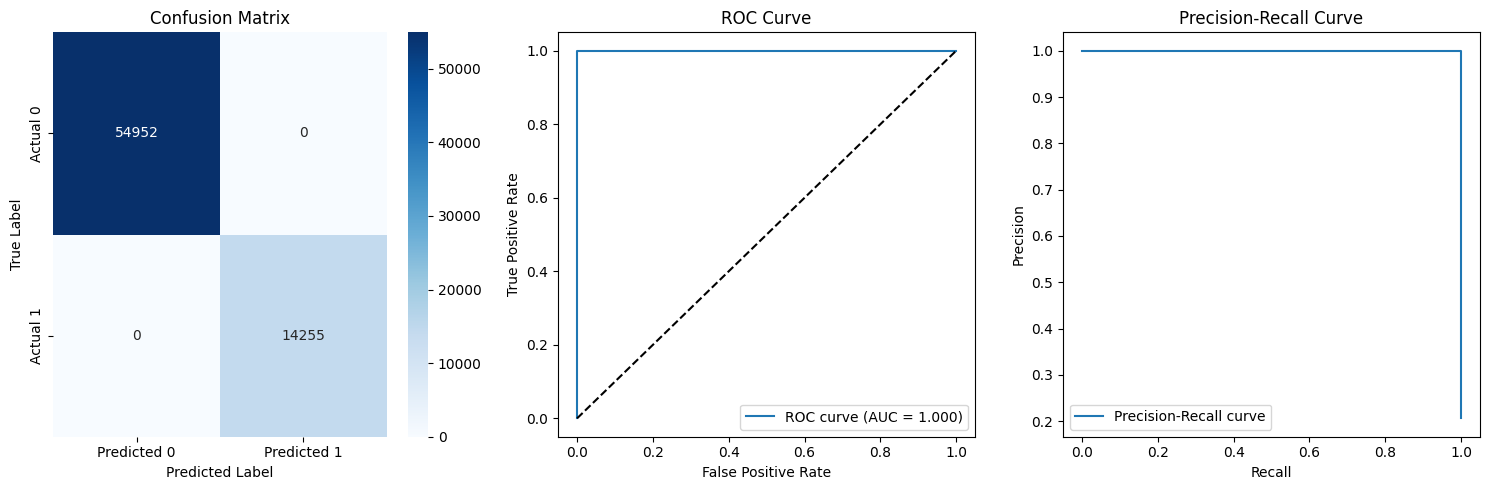


Feature Importance Analysis:


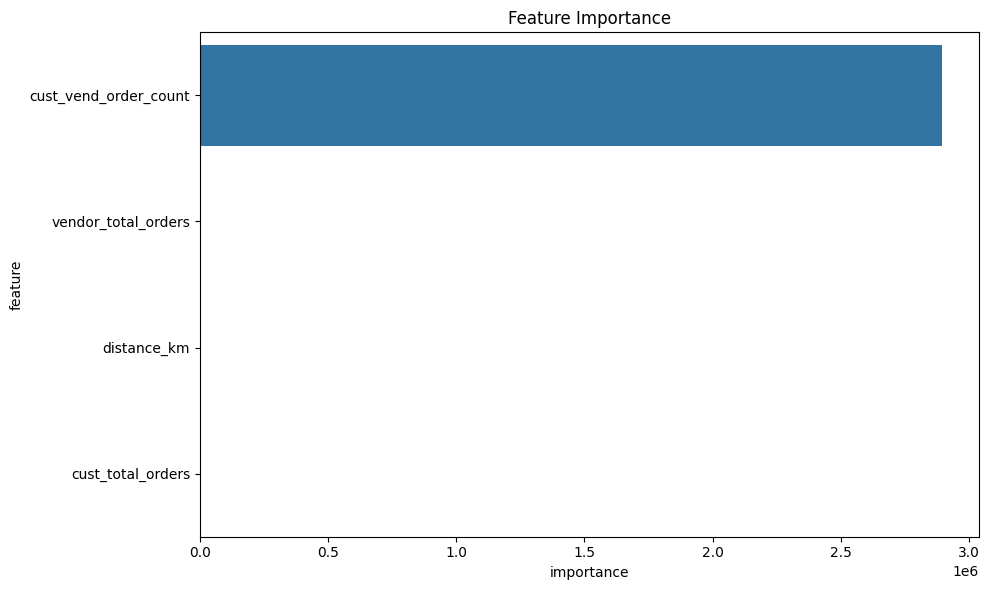

                 feature    importance
3  cust_vend_order_count  2.893443e+06
2    vendor_total_orders  3.088957e-04
0            distance_km  5.178000e-10
1      cust_total_orders  5.454522e-13

Checking for potential issues:
Target variable in features: False
Validation set size: 69207
Class distribution in validation set:
target
0.0    54952
1.0    14255
Name: count, dtype: int64
Any NaN in predictions: False


In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

def evaluate_model(model, X_val, y_val, y_pred_proba=None, threshold=0.5):
    """
    Comprehensive model evaluation
    """
    if y_pred_proba is None:
        y_pred_proba = model.predict(X_val)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_proba >= threshold).astype(int)

    print("=" * 50)
    print("MODEL PERFORMANCE EVALUATION")
    print("=" * 50)

    # Basic metrics
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print()

    # Detailed classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    # Plot confusion matrix
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # ROC Curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(1, 3, 3)
    precision_vals, recall_vals, _ = precision_recall_curve(y_val, y_pred_proba)
    plt.plot(recall_vals, precision_vals, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# 3. Feature Importance Analysis
def plot_feature_importance(model, feature_names):
    """Plot feature importance"""
    importance = model.feature_importance(importance_type='gain')
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_imp)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    return feature_imp

# 4. Evaluate on Validation Set
print("Evaluating on Validation Set:")
val_predictions = model.predict(x_val)
val_metrics = evaluate_model(model, x_val, y_val, val_predictions)

# 5. Feature Importance
print("\nFeature Importance Analysis:")
feature_importance_df = plot_feature_importance(model, feature_columns)
print(feature_importance_df)

# 6. Check for Data Leakage (if you got perfect scores)
print("\nChecking for potential issues:")
print(f"Target variable in features: {'target' in feature_columns}")
print(f"Validation set size: {len(x_val)}")
print(f"Class distribution in validation set:\n{y_val.value_counts()}")
print(f"Any NaN in predictions: {np.isnan(val_predictions).any()}")

In [70]:
# Quick sanity check
print("Quick Performance Check:")
print(f"Validation predictions shape: {val_predictions.shape}")
print(f"Prediction range: [{val_predictions.min():.3f}, {val_predictions.max():.3f}]")
print(f"Mean prediction: {val_predictions.mean():.3f}")

# Check if predictions are reasonable (not all 0 or 1)
if val_predictions.mean() > 0.95 or val_predictions.mean() < 0.05:
    print("WARNING: Predictions are extremely skewed!")

Quick Performance Check:
Validation predictions shape: (69207,)
Prediction range: [0.000, 1.000]
Mean prediction: 0.206


In [72]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(
    lgb.LGBMClassifier(**params),  # Use your best params
    x_train,
    y_train,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc'
)

print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [77]:
import json
from datetime import datetime
import numpy as np

# Create monitoring baseline - convert numpy types to native Python types
monitoring_baseline = {
    'feature_means': {k: float(v) for k, v in x_train.mean().items()},
    'feature_stds': {k: float(v) for k, v in x_train.std().items()},
    'prediction_mean': float(model.predict(x_train).mean()),
    'prediction_std': float(model.predict(x_train).std()),
    'performance_baseline': {
        'precision': float(val_metrics.get('precision', 0)),
        'recall': float(val_metrics.get('recall', 0)),
        'f1': float(val_metrics.get('f1', 0)),
        'roc_auc': float(val_metrics.get('roc_auc', 0))
    },
    'training_date': datetime.now().isoformat(),
    'feature_columns': feature_columns  # This is already a list of strings
}

with open('monitoring_baseline.json', 'w') as f:
    json.dump(monitoring_baseline, f, indent=2)

print("Monitoring baseline saved successfully!")

Monitoring baseline saved successfully!
